# Záróvizsga igazságossága

### Demo

In [132]:
import pandas as pd
import numpy as np

Kiindulásképp azt gondoltam át, milyen adatokat érdemes kinyerni egy kész beosztásból. Az alábbiakat hasznosnak tartottam: 
 1. hány tárgyat tanít egy tanár   
 2. az egyes tárgyakhoz hány tanár és hallgató jut -> átlagos hallgatók száma / tanár
 3. vizsgáztatóként hányszor van beosztva (ennek számolja alapból)
 4. elnökként hányszor van beosztva (ha nem vizsgázató)
 5. tagként hányszor van beosztva (ha nem elnök)
 
(*Alternatív megoldás a 3-5. pontokra:*  egy tanár egy beosztását elképzelhetjük egy 3 elemű vektorként, pl. `[1 0 1]` jelentheti, hogy a tanár vizsgáztatóként és tagként volt jelen. Én végül nem így dolgoztam fel a bemeneti fájlt, így arra a kérdésre nem tud a modellem válaszolni, hogy hányszor volt egy tanár egyszerre vizsgáztató és elnök. Azért gondolom, hogy ez felesleges lehet, mert a munkateher meghatározásához nem kellene kétszer beleszámolni ugyanazt a vizsgaalkalmat. Ha az igazságosság szempontjából mégis úgy döntünk, hogy munkateher szempontjából eltérő egy `[1 0 0]` és egy `[1 1 0]` eset, akkor a fájl feldolgozásakor ezt is tárolni kell.) 

Következő lépésben felállítottam egy példa adathalmazt, melyben az egyes oktatókhoz az alábbi értékeket rendeltem: 
 - hány vizsgán vesznek részt vizsgáztatóként
 - hány tárgyat tanítanak
 - tárgyakra bontva a vizsgázóik száma
 - tárgyakra bontva a hallgatóik száma
Pl. az alábbi számok jellemzik 3 tanár tárgyainak és vizsgázatott hallgatóinak számát. 

In [255]:
A = {"examines": 34, "total_courses": 3, "exams_per_course": {1: 8, 2: 10, 3: 16}, "students_per_course": {1: 8, 2: 10, 3: 8}}
B = {"examines": 17, "total_courses": 1, "exams_per_course": {0: 17}, "students_per_course": {0: 17}}
C = {"examines": 4, "total_courses": 2, "exams_per_course": {3: 0, 4: 4}, "students_per_course": {3: 8, 4: 4}}

df = pd.DataFrame([A, B, C], index = ["A", "B", "C"])
df["spc_sum"] = df.apply(lambda x: sum(x.students_per_course.values()), axis = 1)
df

,examines,total_courses,exams_per_course,students_per_course,spc_sum
A,34,3,"{1: 8, 2: 10, 3: 16}","{1: 8, 2: 10, 3: 8}",26
B,17,1,{0: 17},{0: 17},17
C,4,2,"{3: 0, 4: 4}","{3: 8, 4: 4}",12


Alább pedig az egyes tárgyakról található példaadat:

In [3]:
Courses = {0: {"students": 17, "teachers": 1}, 
           1: {"students": 8, "teachers": 1 }, 
           2: {"students": 10, "teachers": 1}, 
           3: {"students": 16, "teachers": 2}, 
           4: {"students": 4, "teachers": 1}}

Talán érezhető, hogy a "C" tanár az igazságosabbnál kevesebb vizsgára került beosztásra. 
A példa adathalmazban az `exams_per_course` és `students_per_course` oszlopok nem túl elegánsak, ráadásul az utóbbi még redundáns információkat is tartalmaz. Mindkettő igazából csak bizonyos másik értékek meghatározásához kell. A

#### Problémafelvetés

A modellnek erőteljesen zárt világ feltételezése van. Ha egy tanár pl. más tárgyakat is tanít, de ez nem derül ki a beosztásból, ez a tény nem lesz figyelembe véve. Ugyanígy, csak akkor mondhatjuk bizonyossággal, hogy egy tanár betölthet pl. elnöki pozíciót, ha van olyan beosztás, ahol elnök. 
> **Javaslat:** A bemenetből az alábbi kérdésekre biztosabb választ találni. (Pl. az elérhetőségek lapon megtalálható, hogy ki lehet elnök/tag/titkár.)

Előfordulhat, hogy a modell aránytalanságokat talál, de a valóságban ez kívánt viselkedés. Pl. egy tárgyvezető nagyobb százalékban kíván jelen lenni a vizsgákon, mint a többi oktató. Ha a beosztás is ezt figyelembe véve lett elkészítve, akkor az igazságosság megállapításakor pl. súlyokkal tudjuk ezt az információt kezelni. Az általam implementált modell ezzel nem foglalkozik.

### Input feldolgozása

In [4]:
from collections import defaultdict

In [186]:
class ScheduleStats:
    
    _SCHEDULE_DATA_PATH = './data/Beosztáshoz2020osz.xlsx'
    
    def __init__(self):
        self._schedule = self.load_in_sample_data()
        # The function below presupposes the initialized schedule dataframe
        self.courses = self._init_courses()
        # The function below presupposes the initialized schedule and courses dataframes 
        self.teachers = self._init_teachers()
        
    def load_in_sample_data(self):
        path = ScheduleStats._SCHEDULE_DATA_PATH
        sheet_name = '1.kör'
        usecols = "I:K,M:O,Q"
        
        schedule = self._load_in_schedule(path, sheet_name, usecols)
        
        # resolve NaN due to merged cells        
        schedule[['Elnök', 'Tag', 'Titkár']] = schedule[['Elnök', 'Tag', 'Titkár']].fillna(method = 'ffill')
        
        # filter out rows where student name is NaN        
        schedule = schedule.dropna(subset = ['Név'])
        return schedule
        
    def _load_in_schedule(self, path, sheet_name = None, usecols = None):            
        return pd.read_excel(path, sheet_name = sheet_name, usecols = usecols)           
    
    def _init_courses(self):
        if self._schedule is None:
            raise Exception('Parsing course information was called before initializing a "Schedule" DataFrame to work with. ')
        course_data = [
            {"Tárgy": targy, 
             "Hallgatók": len(self._schedule[self._schedule["Vizsgatárgy"] == targy]),
             "Tanárok": len(self._schedule[self._schedule["Vizsgatárgy"] == targy].Vizsgáztató.unique())}
            for targy in self._schedule.Vizsgatárgy.unique()
        ]
        courses = pd.DataFrame(course_data)
        # Egy tanárra jutó hallgatók száma
        courses['ETJH'] = courses.Hallgatók / courses.Tanárok
        courses.ETJH = courses.ETJH.round().astype(int)
        return courses
    
    def _init_teachers(self, workload_weights = np.ones((4))):
        if self._schedule is None:
            raise Exception('Parsing teacher information was called before initializing a "Schedule" DataFrame to work with. ')
        if self.courses is None:
            raise Exception('')
        all_teachers = pd.unique(self._schedule[["Vizsgáztató", "Elnök", "Tag", "Titkár"]].values.ravel('K'))
        teacher_data = list(defaultdict())
        for teacher in all_teachers:
            exam_count = len(self._schedule[self._schedule.Vizsgáztató == teacher])
            pres_count = len(self._schedule[(self._schedule.Vizsgáztató != teacher) & (self._schedule.Elnök == teacher)])
            mem_count = len(self._schedule[(self._schedule.Vizsgáztató != teacher) & (self._schedule.Tag == teacher)])
            sec_count = len(self._schedule[(self._schedule.Vizsgáztató != teacher) & (self._schedule.Titkár == teacher)])
            taught_courses = self._schedule[self._schedule.Vizsgáztató == teacher].Vizsgatárgy.unique()
            # Taught courses index
            TCI = len(taught_courses)
            # Cumulative student index (for the teached subjects)
            CSI = sum(self.courses[self.courses.Tárgy.isin(taught_courses)].Hallgatók)
            # Average students index (per teacher)
            ASI = sum(self.courses[self.courses.Tárgy.isin(taught_courses)].ETJH)
            workload = np.dot([exam_count, pres_count, mem_count, sec_count], workload_weights).item()
            teacher_dict = {"Tanár": teacher, 
             "Vizsga": exam_count, 
             "Elnök": pres_count,
             "Tag": mem_count,
             "Titkár": sec_count,
             "OTI": TCI,
             "KHI": CSI,
             "ÁHI": ASI,
             "Munka": workload,
            }
            teacher_data.append(teacher_dict)
        return pd.DataFrame(teacher_data)    

#### Az osztály használata: 

In [193]:
stats = ScheduleStats()
display("Schedule", stats._schedule)
display("Courses", stats.courses)
display("Teachers", stats.teachers)

'Schedule'

,Név,Konzulens,Vizsgatárgy,Vizsgáztató,Elnök,Tag,Titkár
0,Fógel Péter,Dr. Szegletes Luca,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Asztalos Márk,Dr. Dudás Ákos,Sik Tamás Dávid
1,Kiss Attila Csaba,Dr. Szegletes Luca,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Asztalos Márk,Dr. Dudás Ákos,Sik Tamás Dávid
2,Lauter Kinga Csilla,Dr. Szegletes Luca,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Asztalos Márk,Dr. Dudás Ákos,Sik Tamás Dávid
3,Nagy Péter Ákos,Dr. Szegletes Luca,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Asztalos Márk,Dr. Dudás Ákos,Sik Tamás Dávid
4,Pelle Mátyás,Dr. Szegletes Luca,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Asztalos Márk,Dr. Dudás Ákos,Sik Tamás Dávid
...,...,...,...,...,...,...,...
127,Erdős Ádám,Simon Gábor,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Kovács Tibor,Dr. Dudás Ákos,Sik Tamás Dávid
128,Herdey Márton Vilmos,Simon Gábor,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Kovács Tibor,Dr. Dudás Ákos,Sik Tamás Dávid
129,Martonosi Máté,Simon Gábor,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Kovács Tibor,Dr. Dudás Ákos,Sik Tamás Dávid
130,Mucsi Róbert,Simon Gábor,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Kovács Tibor,Dr. Dudás Ákos,Sik Tamás Dávid


'Courses'

,Tárgy,Hallgatók,Tanárok,ETJH
0,Adatvezérelt rendszerek,47,6,8
1,Ipari irányítástechnika,2,1,2
2,Mikrokontroller alapú rendszerek,13,3,4
3,Beágyazott operációs rendszerek és kliens alka...,9,2,4
4,Alkalmazásfejlesztési környezetek,13,2,6
5,3D grafikus rendszerek,1,1,1
6,Kooperatív és tanuló rendszerek,1,1,1
7,Objektumorientált szoftvertervezés,4,1,4
8,Kliensoldali technológiák,32,4,8
9,Hálózati technológiák és alkalmazások,1,1,1


'Teachers'

,Tanár,Vizsga,Elnök,Tag,Titkár,OTI,KHI,ÁHI,Munka
0,Dr. Dudás Ákos,23,0,0,0,1,47,8,23.0
1,Imre Gábor,6,0,0,0,1,47,8,6.0
2,Dr. Asztalos Márk,2,9,0,0,1,47,8,11.0
3,Kovács Gábor,2,0,0,0,1,2,2,2.0
4,Dr. Tevesz Gábor,7,4,0,0,1,13,4,11.0
5,Szabó Zoltán,6,0,0,0,2,22,8,6.0
6,Kovács Ádám,3,0,0,19,1,47,8,22.0
7,Dr. Csorba Kristóf,11,11,0,0,1,13,6,22.0
8,Dr. Szécsi László,1,0,0,0,1,1,1,1.0
9,Dr. Dobrowiecki Tadeusz Pawel,1,0,0,0,1,1,1,1.0


### Regresszió

In [250]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [231]:
def pure_LR(X, y):
    return LinearRegression().fit(X,y) 

In [238]:
def LR_PR_Pipeline(X, y, degree):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    return pipeline.fit(X, y)

In [225]:
stats = ScheduleStats()
input_columns = ['OTI', 'KHI', 'ÁHI']
data = stats.teachers[(stats.teachers[input_columns] != 0).all(axis = 1)]

X, y = data[input_columns], data.Munka

In [253]:
model = pure_LR(X,y)
print("R\u00b2 = ", model.score(X,y))

R² =  0.3582615792721434


In [254]:
model = LR_PR_Pipeline(X, y, degree = 3)
print("R\u00b2 = ", model.score(X, y))

R² =  0.4930153879733712


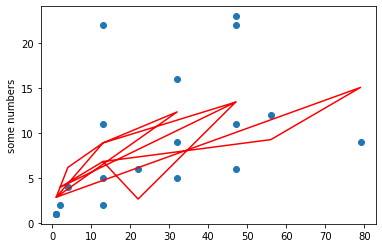

In [227]:
plt.scatter(X.KHI, y)
plt.plot(X.KHI, y_pred, 'r')
plt.ylabel('some numbers')
plt.show()

https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html
Érdemes lenne egy pipelinet bevezetni, polinomiális regressziót is tesztelve. 

> **Probléma**: Az olyan tanárokat, akiknek nincsen tárgya, külön kell kezelni. 

> **Probléma**: Elég gyenge a korreláció. Kísérletezés különböző polinom fokokkal, más modellekkel?

## Lehetséges fejlesztési irányok

Feltehetően nem lesz ugyanolyan sémájú az összes bemeneti excel fájlunk. `A ScheduleStats` osztály jelen formájában egy konkrét bemeneti fájlból indul ki. Érdemes lehet a beolvasott fájl feldolgozását lambda függvényeken keresztül elvégezni és a mostani, fájlspecifikus feldolgozást alapértelmezettként kezelni. Alternatíva lehet egy leszármazott osztályban implementálni az összes, a 2020-as bemeneti Excel fájlra jellemző feldolgozást, így növelve a kód újrafelhasználhatóságát.  

A kód követhetősége érdekében érdemes lehet áttérni mindenhol az angol terminológiára. A DataFramek oszlopnevei egyelőre szimplán átveszik a beolvasott fájl fejléceit, így a kódban is sok helyen zavaró lehet a magyar. (Másrészről viszont igaz, hogy a kód teljes egészében a BME-VIK záróvizsgabeosztásainak igazságosságával foglalkozik, helyénvaló lehet meghagyni változatlanul az oszlopokat.)